# FINESST Plots

1. Figure 1 with just the longwave panels.  

2. AIRS Spectral OLR trends with temperature trends in the sidebar.

## 1. Figure 1 with just the longwave panels.  

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [2]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [3]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [4]:
giss_tsel = giss1.sel(time=slice('2001-01','2020-12'))['air']

In [5]:
giss1.close()

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [6]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [7]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = add_weights(xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir))

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = add_weights(all_ceres['toa_lw_all_mon'])

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [8]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [9]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [10]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for ii,(i,_month) in enumerate(subset_data.groupby('time.month')): # fix to handle not all months
        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        # ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Calculate trends and statistical significance

#### CERES OLR

In [11]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [12]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif2(ceres_olr_subset)

#### AIRS OLR

In [13]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airs_broadband_olr = add_weights(xr.open_dataset('%s/%s/olr_broadband.nc' % (airs_dir,'arc_proc/')))

In [14]:
# Subset data so computations are lighter and significance tests make sense
airs_olr_subset = airs_broadband_olr['olr'].sel(time=slice('2003-01-01','2019-12-31'),lat=slice(58,90)).mean(dim=['lon','orbit_pass'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [15]:
olr_airs_trends,olr_airs_statsig,olr_airs_notnull = compute_trends_n_signif2(airs_olr_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/

#### Temperature from GISStemp

In [16]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [17]:
gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif2(gisstemp_subset)

### Plot summary data

#### Wrap data for better visualization

In [43]:
gisstemp_trends_wrapped = xr.concat([gisstemp_trends,gisstemp_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_statsig_wrapped = xr.concat([gisstemp_statsig,gisstemp_statsig[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

olr_airs_trends_wrapped = xr.concat([olr_airs_trends,olr_airs_trends[0].assign_coords({'month':13})],dim='month')
olr_airs_statsig_wrapped = xr.concat([olr_airs_statsig,olr_airs_statsig[0].assign_coords({'month':13})],dim='month')

Text(0.5, 0.99, 'Observed Trends')

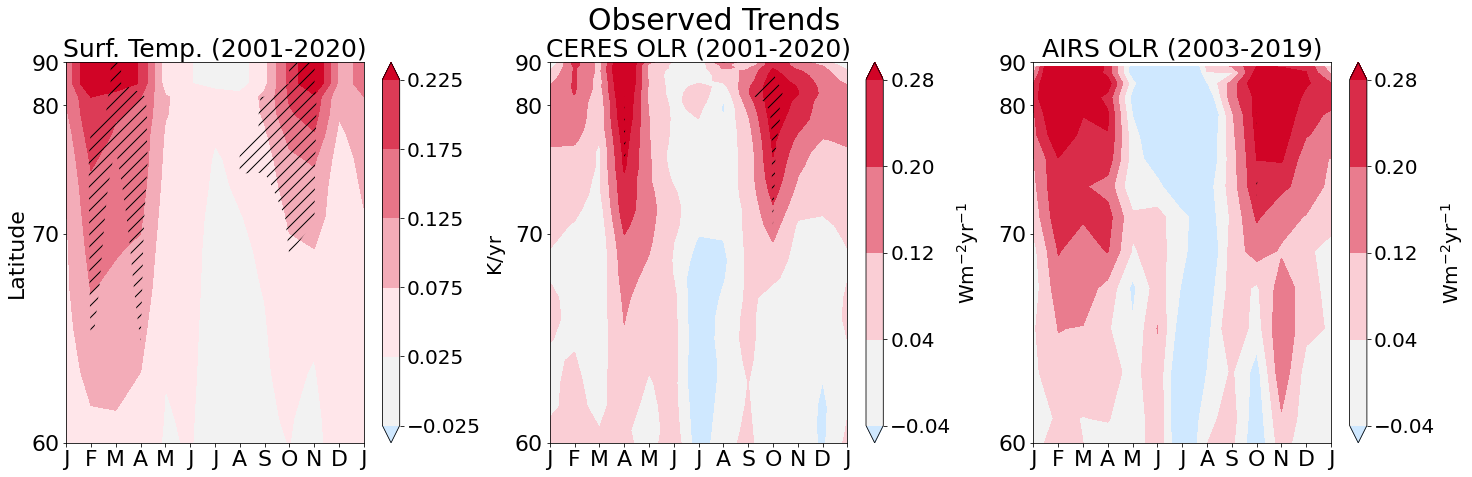

In [53]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=5, as_cmap=True)

fig1,axs = plt.subplots(nrows=1,ncols=3,figsize=(24,7))
fig1.subplots_adjust(wspace=0.3,hspace=0.2)

axes = axs.flat

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)

axes[0].set_ylabel('Latitude',fontsize=22)

lat_weighted0 = np.sin(np.pi/180*gisstemp_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(gisstemp_trends_wrapped['month'],lat_weighted0,gisstemp_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im0.cmap.set_under((0.81,0.91,1.00))
stip = axes[0].contourf(gisstemp_statsig_wrapped['month'],lat_weighted0,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Surf. Temp. (2001-2020)',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='K/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*olr_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(olr_trends_wrapped['month'],lat_weighted1,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im1.cmap.set_under((0.81,0.91,1.00))
stip = axes[1].contourf(olr_statsig_wrapped['month'],lat_weighted1,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('CERES OLR (2001-2020)',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*olr_airs_trends['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(olr_airs_trends_wrapped['month'],lat_weighted2,olr_airs_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im2.cmap.set_under((0.81,0.91,1.00))
stip = axes[2].contourf(olr_airs_statsig_wrapped['month'],lat_weighted2,olr_airs_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('AIRS OLR (2003-2019)',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('Observed Trends',fontsize=30,y=0.99)

In [23]:
to_png(fig1,'observedtLWrends_2panel')

## 2. AIRS Spectral OLR trends with temperature trends in the sidebar.

#### Load pre-calculated AIRS trends (lon. averaged)

In [28]:
airs_files = glob.glob('%s/proc/*' % airs_dir)
airs_files

['/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20190201.M01.L3_SpecOLR.std.v06_01_00.M.191116170940.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20140201.M01.L3_SpecOLR.std.v06_01_00.M.191116174830.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20080601.M01.L3_SpecOLR.std.v06_01_00.M.191116173031.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20110801.M01.L3_SpecOLR.std.v06_01_00.M.191116174037.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030801.M01.L3_SpecOLR.std.v06_01_00.M.191116171523.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20151101.M01.L3_SpecOLR.std.v06_01_00.M.191116175401.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20110501.M01.L3_SpecOLR.std.v06_01_00.M.191116173950.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20090801.M01.L3_SpecOLR.std.v06_01_00.M.191116173410.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20080201.M01.L3_SpecOLR.std.v06_01_00.M.1911161729

In [20]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'

all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))
all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))    

In [21]:
all_data_spec_olr_wgtd = add_weights(all_data_spec_olr['TREND'])
all_data_spec_olr_clr_wgtd = add_weights(all_data_spec_olr_clr['TREND'])

In [22]:
all_data_spec_olr_statsig_wgtd = add_weights(all_data_spec_olr['STATSIG'])
all_data_spec_olr_clr_statsig_wgtd = add_weights(all_data_spec_olr_clr['STATSIG'])

In [23]:
all_data_spec_olr.close()
all_data_spec_olr_clr.close()

olr_trend_spatavg = masked_average(all_data_spec_olr_wgtd,dim=['lat'],
                                   weights=all_data_spec_olr_wgtd['cell_weight'],mask=all_data_spec_olr_wgtd['lat']<70)
olr_clr_trend_spatavg = masked_average(all_data_spec_olr_clr_wgtd,dim=['lat'],
                                       weights=all_data_spec_olr_clr_wgtd['cell_weight'],mask=all_data_spec_olr_clr_wgtd['lat']<70)

olr_statsig_spatavg = masked_average(all_data_spec_olr_statsig_wgtd,dim=['lat'],
                                     weights=all_data_spec_olr_statsig_wgtd['cell_weight'],mask=all_data_spec_olr_statsig_wgtd['lat']<70)
olr_clr_statsig_spatavg = masked_average(all_data_spec_olr_clr_statsig_wgtd,dim=['lat'],
                                         weights=all_data_spec_olr_clr_statsig_wgtd['cell_weight'],mask=all_data_spec_olr_clr_statsig_wgtd['lat']<70)

### Nice plot for OLR

In [24]:
gisstemp_AIRSsubset = giss_tsel.sel(lat=slice(None,59),time=slice('2003-01-01','2018-12-31'))

gisstemp_AIRStrends,gisstemp_AIRSstatsig,gisstemp_AIRSnotnull = compute_trends_n_signif2(gisstemp_AIRSsubset)
gisstemp_AIRStrends_wgtd = add_weights(gisstemp_AIRStrends)
gisstemp_AIRStrends_spatavg = masked_average(gisstemp_AIRStrends_wgtd,weights=gisstemp_AIRStrends_wgtd['cell_weight'],dim=['lat','lon'])

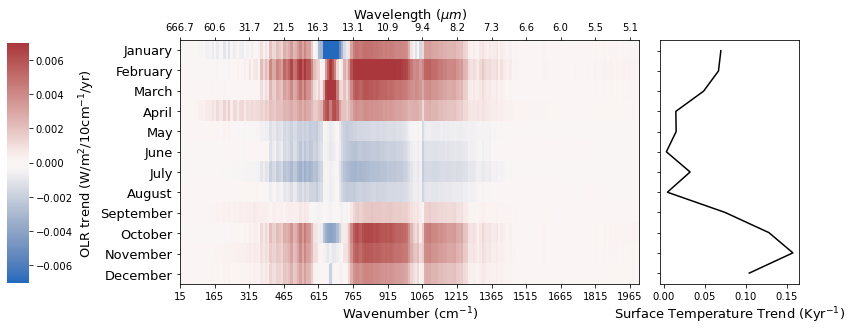

In [25]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

nuthin = 199*[None]

# Only take every 15th wnum label (there must be a better way)
new_labels = [olr_trend_spatavg.wnum[i].values if i%15 == 0 else b for  i,b in enumerate(nuthin)]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

fig1 = plt.figure(constrained_layout=False,figsize=(20,4.5))
gs1 = fig1.add_gridspec(nrows=3, ncols=4, left=0.05, right=0.48, wspace=0.15,hspace=0.4)
f1_ax1 = fig1.add_subplot(gs1[:, :3])
f1_ax2 = fig1.add_subplot(gs1[:, 3:])

# Plot the average OLR
# olr_trend_spatavg[:,:,0].groupby('time.month').mean('time').mean('month').plot(ax=f1_ax1,xlim=[15,1995])
# f1_ax1.set_title('AIRS OLR 2002-09 to 2019-06')# (Wm$^{-2}$)')
# fig1.suptitle('AIRS OLR 2002-09 to 2019-06 (Wm$^{-2}$)')

cbar_axh2 = fig1.add_axes([-0.07, 0.13, 0.015, 0.74])
# cbar_axh2 = fig1.add_axes([0.5, 0.15, 0.02, 0.72])

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',
            xticklabels=new_labels,yticklabels=mon_dict.values(),
           ax=f1_ax1,cbar_ax=cbar_axh2,vmin=-0.007,vmax=0.007)

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)', fontsize=13)


f1_ax2.plot(gisstemp_AIRStrends_spatavg,gisstemp_AIRStrends_spatavg.month,color='black')

# f1_ax2.set_xlabel('Wavenumber (cm$^{-1}$)')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

def tick_function1(X):
    return ["%.0f" % z for z in X]

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

f1_ax1.set_xticks(tick_indices)
f1_ax1b.set_xticks(tick_indices)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
f1_ax1b.set_xticklabels(tick_function2(tick_values))

f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=13)
f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=13) # W/m$^{2}$/10cm$^{-1}$

f1_ax1.set_yticklabels(f1_ax1.get_yticklabels(),fontdict={'fontsize':13})

f1_ax2.set_xlabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=13)
f1_ax2.set_yticks(np.arange(1,12.1,1))
noout = f1_ax2.set_yticklabels(12*[None])

In [162]:
to_png(fig1,"spectraltrends_withtemp",bbox_inches="tight")

Text(0.5, 1.0, 'Spectral OLR Trends (70-90N)')

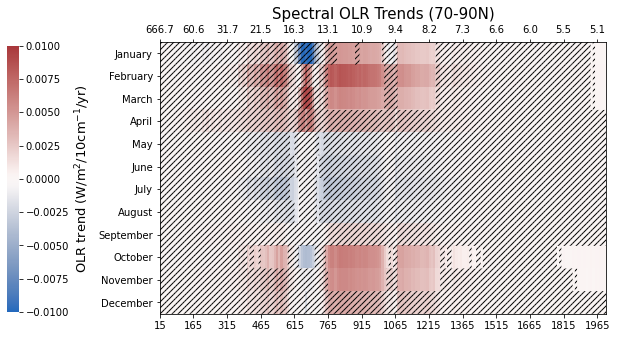

In [55]:
fig_sig,ax_sig = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax_sigb = ax_sig.twiny()

statsig_thresh = 95

mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

def tick_function1(X):
    out = ["%.0f" % z for z in X]
    return out

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

cbar_axh2 = fig_sig.add_axes([-0.14, 0.13, 0.02, 0.74])

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',ax=ax_sig,cbar_ax=cbar_axh2,vmin=-0.01,vmax=0.01)#,mask=olr_statsig_spatavg<statsig_thresh)

zm = olr_trend_spatavg.where(olr_statsig_spatavg<statsig_thresh)
x = np.arange(0,olr_trend_spatavg.shape[1]+1)       
y = np.arange(0,olr_trend_spatavg.shape[0]+1)
ax_sig.pcolor(x, y, zm, hatch='////', alpha=0.)

ax_sig.set_xticks(tick_indices)
ax_sig.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
ax_sig.set_yticklabels(mon_dict.values(),fontdict={'fontsize':10,'rotation':0})

ax_sigb.set_xticks(tick_indices)
ax_sigb.set_xbound(ax_sig.get_xbound())
ax_sigb.set_xticklabels(tick_function2(tick_values))

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)', fontsize=13)

ax_sig.set_title('Spectral OLR Trends (70-90N)',fontsize=15)

Trends in the stratosphere are large but not significant. This indicates the importance of variability in stratospheric temperatures. When looking for trends by aggregating channels, it's probably best to omit channels sounding the stratosphere.

Why are April trends not statistically significant?

Text(0.5, 1.0, 'Spectral OLR Trends (70-90N)')

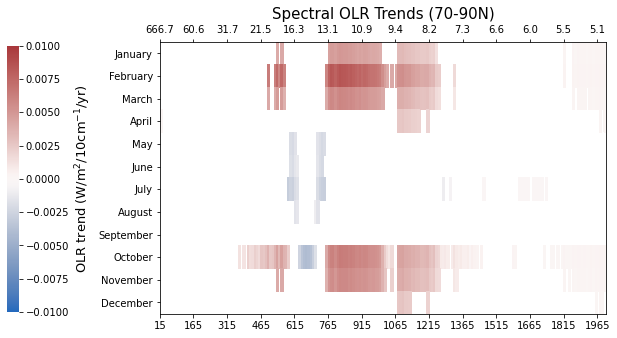

In [56]:
fig_sig,ax_sig = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
ax_sigb = ax_sig.twiny()

statsig_thresh = 90

mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

def tick_function1(X):
    out = ["%.0f" % z for z in X]
    return out

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

cbar_axh2 = fig_sig.add_axes([-0.14, 0.13, 0.02, 0.74])

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',ax=ax_sig,cbar_ax=cbar_axh2,vmin=-0.01,vmax=0.01,
                mask=olr_statsig_spatavg<statsig_thresh)#,mask=olr_statsig_spatavg<statsig_thresh)

zm = olr_trend_spatavg.where(olr_statsig_spatavg<statsig_thresh)
x = np.arange(0,olr_trend_spatavg.shape[1]+1)       
y = np.arange(0,olr_trend_spatavg.shape[0]+1)
# ax_sig.pcolor(x, y, zm, hatch='////', alpha=0.)

ax_sig.set_xticks(tick_indices)
ax_sig.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
ax_sig.set_yticklabels(mon_dict.values(),fontdict={'fontsize':10,'rotation':0})

ax_sigb.set_xticks(tick_indices)
ax_sigb.set_xbound(ax_sig.get_xbound())
ax_sigb.set_xticklabels(tick_function2(tick_values))

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)', fontsize=13)

ax_sig.set_title('Spectral OLR Trends (70-90N)',fontsize=15)

What are we looking at here?

1. Surface warming in the Fall and Winter coming through the atmospheric window and at ~5um. Note no significant changes in December.  

2. Cooling near the stratosphere/upper troposphere in the summer? It's happening at bands off the CO2 absorption peak, so it must be lower in the atmosphere.

What band is giving us consistent data (i.e. what wavelength ranges)?

In [28]:
feb_airs_statsig = olr_statsig_spatavg.sel(month=(olr_statsig_spatavg['month']==2))

In [29]:
feb_airs_statsig['wnum'][(feb_airs_statsig>95).values.squeeze()]

<xarray.DataArray 'wnum' (wnum: 48)>
array([ 765.,  775.,  785.,  795.,  805.,  815.,  825.,  835.,  845.,  855.,
        865.,  875.,  885.,  895.,  905.,  915.,  925.,  935.,  945.,  955.,
        965.,  975.,  985.,  995., 1005., 1075., 1085., 1095., 1105., 1115.,
       1125., 1135., 1145., 1155., 1165., 1175., 1185., 1195., 1205., 1215.,
       1225., 1235., 1935., 1955., 1965., 1975., 1985., 1995.], dtype=float32)
Coordinates:
  * wnum     (wnum) float32 765.0 775.0 785.0 795.0 ... 1975.0 1985.0 1995.0
Attributes:
    units:                  cm-1
    long_name:              OLR wavenumber band centers
    description:            OLR wavenumber band centers
    coverage_content_type:  coordinate
    bounds:                 olr_wnum_bnds

Ok 765-1005 cm-1 and 1075-1235 cm-1 is the most open window (channels with significant trends).

In [30]:
def is_window(wnum):
    '''
    Function to use with .sel() to subset AIRS spectral OLR data and select a "window" region.
    '''
    window = [765.,  775.,  785.,  795.,  805.,  815.,  825.,  835.,  845.,  855.,
              865.,  875.,  885.,  895.,  905.,  915.,  925.,  935.,  945.,  955.,
              965.,  975.,  985.,  995., 1005., 1075., 1085., 1095., 1105., 1115.,
              1125., 1135., 1145., 1155., 1165., 1175., 1185., 1195., 1205., 1215.,
              1225., 1235.] #, 1935., 1955., 1965., 1975., 1985., 1995.]
    
    return np.isin(wnum,window)
    # return ((wnum >= 760) & (month <= 1010)) | ((wnum >= 1070) & (month <= 1240))

In [87]:
is_window(feb_airs_statsig['wnum']).shape

(199,)

In [88]:
feb_airs_statsig.shape

(1, 199)

In [39]:
feb_airs_statsig.squeeze()[is_window(feb_airs_statsig['wnum'])]

<xarray.DataArray (wnum: 42)>
array([95.18862 , 95.53738 , 95.88431 , 95.364334, 96.03498 , 96.20787 ,
       96.376144, 96.502884, 96.447296, 96.37225 , 96.28232 , 96.24704 ,
       96.141174, 96.07112 , 96.45278 , 96.47176 , 96.4901  , 96.519165,
       96.44332 , 96.59423 , 96.63746 , 96.59591 , 96.800476, 96.888596,
       96.16615 , 97.162315, 97.39809 , 97.48967 , 97.18711 , 97.166046,
       97.20274 , 96.9514  , 96.85785 , 96.59943 , 96.71948 , 96.41642 ,
       96.52412 , 96.78667 , 97.07511 , 96.24985 , 96.08475 , 96.3037  ],
      dtype=float32)
Coordinates:
  * wnum     (wnum) float32 765.0 775.0 785.0 795.0 ... 1215.0 1225.0 1235.0
    month    int64 2

### How about the trends we saw in CERES OLR?

In [37]:
olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

In [38]:
olr_airs_trends_wrapped = xr.concat([olr_airs_trends,olr_airs_trends[0].assign_coords({'month':13})],dim='month')
olr_airs_statsig_wrapped = xr.concat([olr_airs_statsig,olr_airs_statsig[0].assign_coords({'month':13})],dim='month')

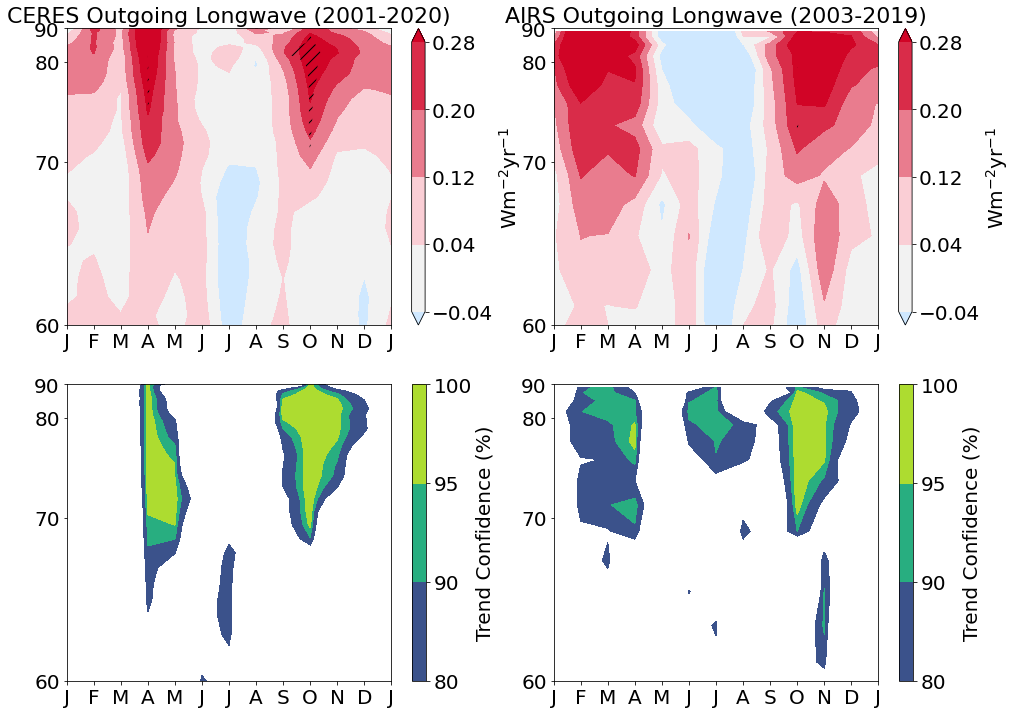

In [86]:
fig_olr,ax_olr = plt.subplots(2,2,figsize=(16,12))
ax_olr = ax_olr.flat

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=5, as_cmap=True)

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in ax_olr:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=20)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=20)

lat_weighted0 = np.sin(np.pi/180*olr_trends['lat'])
cmap0 = copy.copy(palette)

im0 = ax_olr[0].contourf(olr_trends_wrapped['month'],lat_weighted0,olr_trends_wrapped.transpose('lat','month'),
                         cmap=cmap0,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im0.cmap.set_under((0.81,0.91,1.00))
stip = ax_olr[0].contourf(olr_statsig_wrapped['month'],lat_weighted0,olr_statsig_wrapped.transpose('lat','month'),
                          colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')

lat_weighted1 = np.sin(np.pi/180*olr_airs_trends['lat'])
cmap1 = copy.copy(palette)

im1 = ax_olr[1].contourf(olr_airs_trends_wrapped['month'],lat_weighted1,olr_airs_trends_wrapped.transpose('lat','month'),
                         cmap=cmap1,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im1.cmap.set_under((0.81,0.91,1.00))
stip = ax_olr[1].contourf(olr_airs_statsig_wrapped['month'],lat_weighted1,olr_airs_statsig_wrapped.transpose('lat','month'),
                          colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')


ax_olr[0].set_title('CERES Outgoing Longwave (2001-2020)',fontsize=22)
cbar0 = plt.colorbar(im0,ax=ax_olr[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

ax_olr[1].set_title('AIRS Outgoing Longwave (2003-2019)',fontsize=22)
cbar1 = plt.colorbar(im1,ax=ax_olr[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*olr_statsig_wrapped['lat'])
cmap2 = 'viridis' #sns.color_palette("viridis")#, as_cmap=True)

im2 = ax_olr[2].contourf(olr_statsig_wrapped['month'],lat_weighted2,olr_statsig_wrapped.transpose('lat','month'),
                          cmap=cmap2,extend='neither',levels=[80,90,95,100]) # np.arange(80,101,5)
cbar2 = plt.colorbar(im2,ax=ax_olr[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Trend Confidence (%)',fontsize=20)

lat_weighted3 = np.sin(np.pi/180*olr_airs_statsig_wrapped['lat'])
cmap3 = 'viridis' #sns.color_palette("viridis")#, as_cmap=True)

im3 = ax_olr[3].contourf(olr_airs_statsig_wrapped['month'],lat_weighted3,olr_airs_statsig_wrapped.transpose('lat','month'),
                          cmap=cmap3,extend='neither',levels=[80,90,95,100])
cbar3 = plt.colorbar(im3,ax=ax_olr[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Trend Confidence (%)',fontsize=20)

We see a big increase in outgoing longwave radiation in April. Is this a "real" trend? What is going on? Notably, the trend is not as narrow in the shorter AIRS record, suggesting that some of the strength of the trend results from the shorter CERES record. Similarly, the reduction in summer OLR in AIRS is moderated in the CERES record. Takeaway, the general trends are robust, but specifics are pretty variable.

__OLR change in the spring is of a similar magnitude to the fall, but temperature increase in the fall is ~2x greater than that in the spring. Question: What process drives the spring OLR increase? Is likely not surface temperature increases alone.__ Can spectral observations answer this question?

__Is the AIRS trend a sum of two different sharp trends (one in February and another in April?).__ The spectral obs might suggest so. Are these a few specific events skewing the trend, and if so what are they?

#### 1. Plot OLR in April spatially for each year in this record. Get a sense of the spatial pattern of OLR.

In [62]:
ceres_olr_spatialsubset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90))

In [63]:
ceres_olr_april = ceres_olr_spatialsubset.sel(time=(ceres_olr_spatialsubset['time.month']==4))
# ceres_olr_april = ceres_olr_spatialsubset[ceres_olr_spatialsubset['time.month']==4]

For CERES OLR.

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


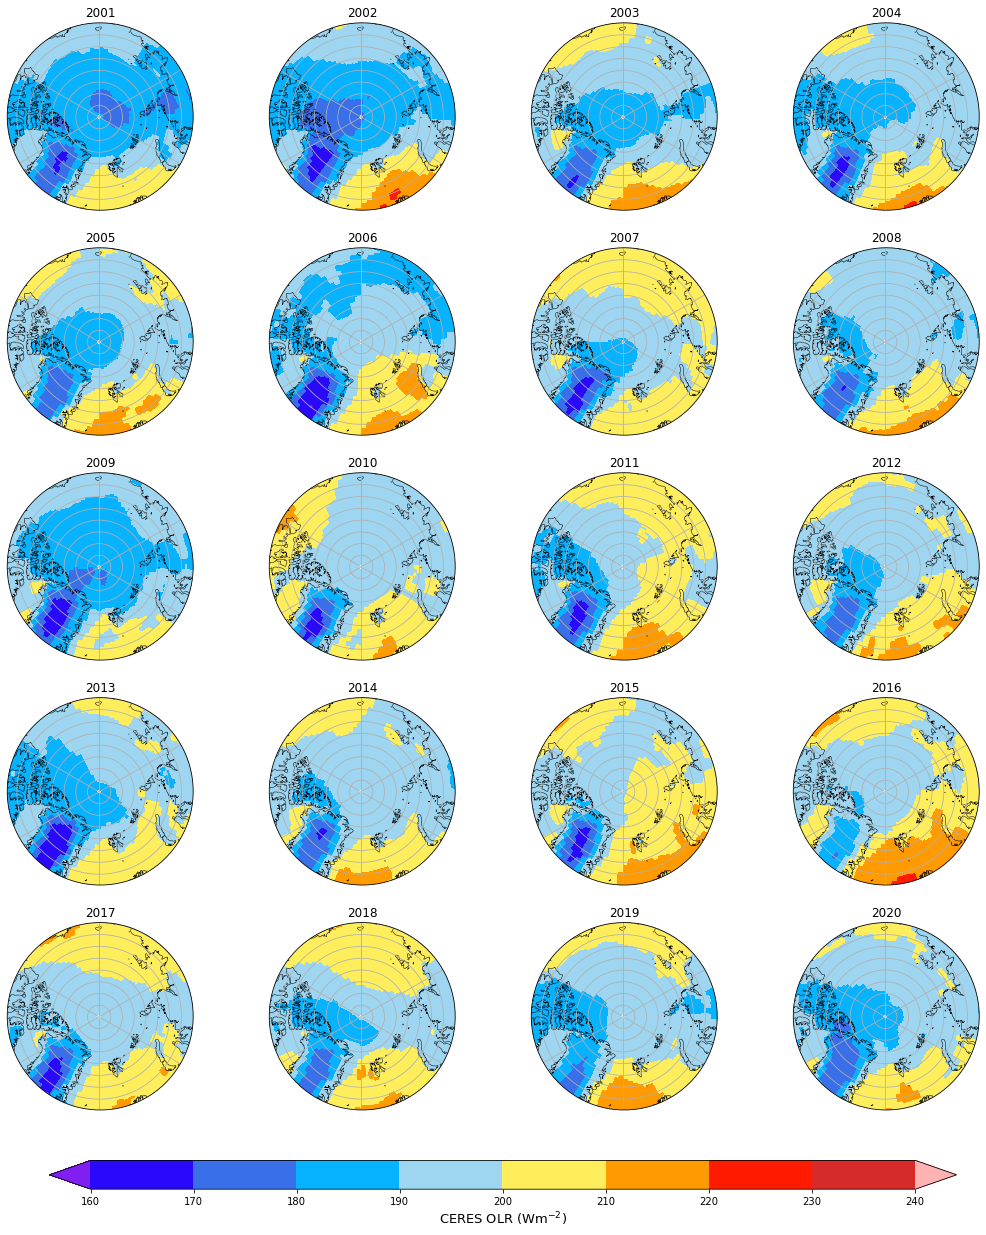

In [64]:
fig,axs = sp_map(nrows=5, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,20])

for i,(ax,month) in enumerate(zip(axs.flat,ceres_olr_april)):
    polarCentral_set_latlim([70,90], ax)
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),
                     cmap=cmaps.ncl_default,levels=np.linspace(160,240,9),extend='both')
    
    add_map_features(ax)
    
    label = month['time.year'].values
    
    ax.set_title(label,fontsize=12)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES OLR (Wm$^{-2}$)",fontsize=13)

For AIRS Broadband OLR.

In [78]:
airs_broadband_olr_arc = airs_broadband_olr.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90))
airs_broadband_olr_arc_april = airs_broadband_olr_arc.sel(time=(airs_broadband_olr_arc['time.month']==4)).mean(dim='orbit_pass')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


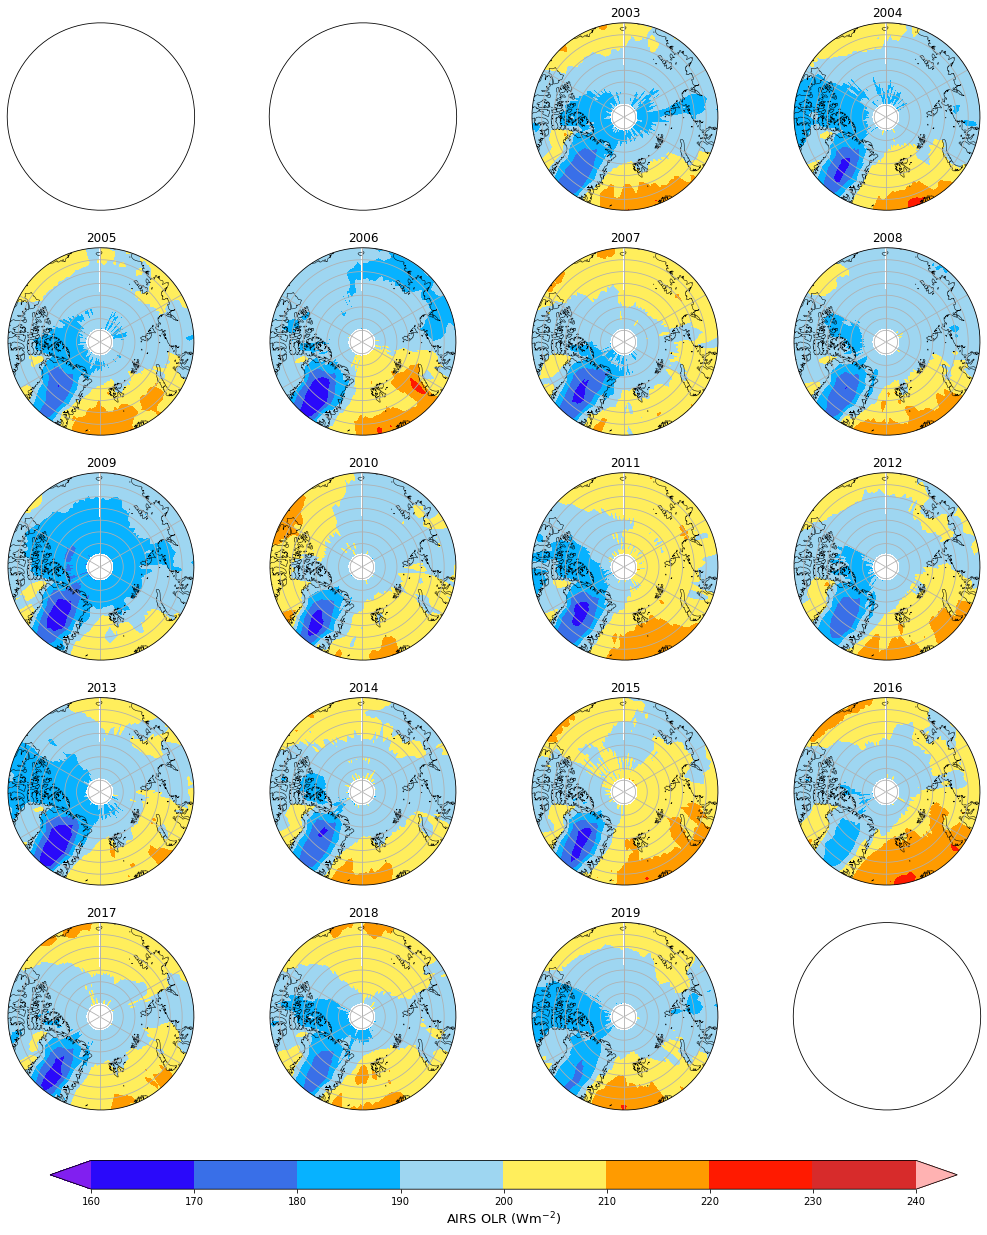

In [79]:
fig,axs = sp_map(nrows=5, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,20])

for i,(ax,month) in enumerate(zip(axs.flat[2:],airs_broadband_olr_arc_april['olr'])):
    polarCentral_set_latlim([70,90], ax)
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),
                     cmap=cmaps.ncl_default,levels=np.linspace(160,240,9),extend='both')
    
    add_map_features(ax)
    
    label = month['time.year'].values
    
    ax.set_title(label,fontsize=12)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("AIRS OLR (Wm$^{-2}$)",fontsize=13)

I can see the warming (increased OLR) by looking at these plots, but I can't identify a specific region where the OLR is increasing.

April OLR trends for CERES

In [65]:
ceres_olr_april_trends,ceres_olr_april_statsig,ceres_olr_april_notnull = compute_trends_n_signif2(ceres_olr_april)

In [67]:
ceres_olr_april_tseries = masked_average(ceres_olr_april,dim=['lat','lon'],weights=ceres_olr_april['cell_weight'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'CERES April OLR')

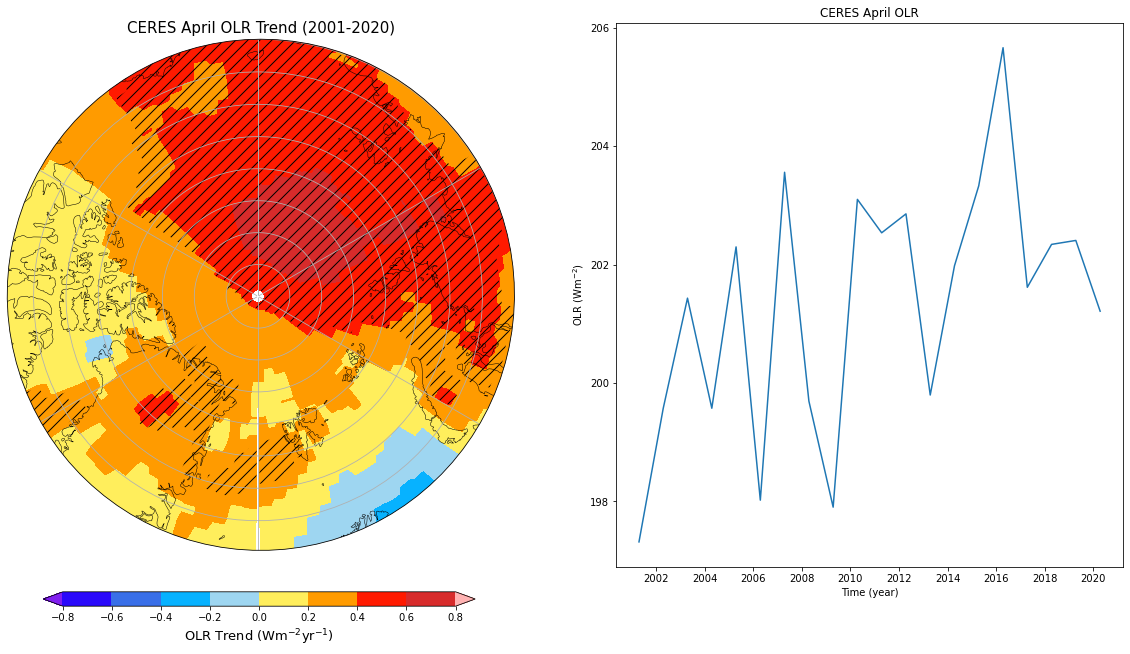

In [71]:
fig,axs = sp_map(nrows=1, ncols=2, projection=ccrs.NorthPolarStereo(), figsize=[20,10])

axs[1].remove()
axs2 = fig.add_subplot(1, 2, 2) # remove 2nd subplot and replace it with one with no preset projection

polarCentral_set_latlim([70,90], axs[0])
    
im = axs[0].contourf(ceres_olr_april_trends['lon'],ceres_olr_april_trends['lat'],ceres_olr_april_trends[0,:,:],transform=ccrs.PlateCarree(),
                 cmap=cmaps.ncl_default,extend='both',levels=np.linspace(-0.8,0.8,9))

stip = axs[0].contourf(ceres_olr_april_statsig['lon'],ceres_olr_april_statsig['lat'],ceres_olr_april_statsig[0,:,:],transform=ccrs.PlateCarree(),#)
                    levels=[0,95,100],hatches=[None,'//'],extend='neither',colors='none',)

add_map_features(axs[0])

cbar_axh = fig.add_axes([0.15, 0.07, 0.30, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)
axs[0].set_title("CERES April OLR Trend (2001-2020)",fontsize=15)

axs2.plot(ceres_olr_april_tseries['time'],ceres_olr_april_tseries)
axs2.set_xlabel('Time (year)')
axs2.set_ylabel('OLR (Wm$^{-2}$)')
axs2.set_title('CERES April OLR')

In [80]:
airs_olr_april_trends,airs_olr_april_statsig,airs_olr_april_notnull = compute_trends_n_signif2(airs_broadband_olr_arc_april['olr'])

Text(0.5, 1.0, 'AIRS April OLR')

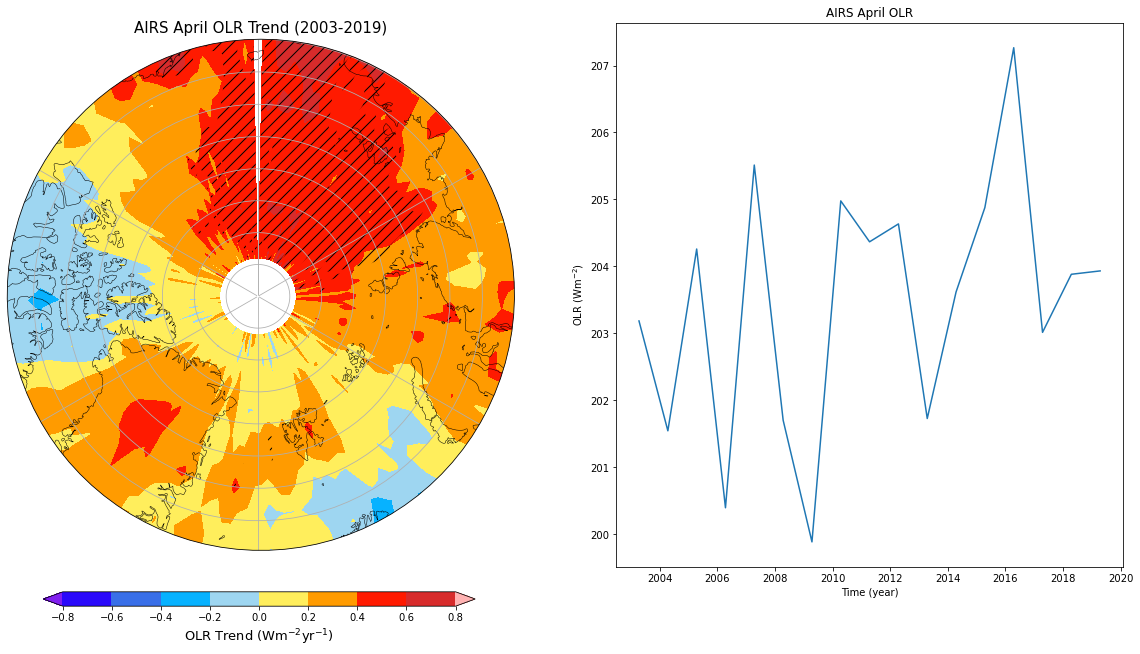

In [84]:
fig,axs = sp_map(nrows=1, ncols=2, projection=ccrs.NorthPolarStereo(), figsize=[20,10])

axs[1].remove()
axs2 = fig.add_subplot(1, 2, 2) # remove 2nd subplot and replace it with one with no preset projection

polarCentral_set_latlim([70,90], axs[0])
    
im = axs[0].contourf(airs_olr_april_trends['lon'],airs_olr_april_trends['lat'],airs_olr_april_trends[0,:,:],transform=ccrs.PlateCarree(),
                 cmap=cmaps.ncl_default,extend='both',levels=np.linspace(-0.8,0.8,9))

stip = axs[0].contourf(airs_olr_april_statsig['lon'],airs_olr_april_statsig['lat'],airs_olr_april_statsig[0,:,:],transform=ccrs.PlateCarree(),#)
                    levels=[0,95,100],hatches=[None,'//'],extend='neither',colors='none',)

add_map_features(axs[0])

cbar_axh = fig.add_axes([0.15, 0.07, 0.30, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)
axs[0].set_title("AIRS April OLR Trend (2003-2019)",fontsize=15)

axs2.plot(airs_olr_april_tseries['time'],airs_olr_april_tseries)
axs2.set_xlabel('Time (year)')
axs2.set_ylabel('OLR (Wm$^{-2}$)')
axs2.set_title('AIRS April OLR')

Again, AIRS and CERES trends are quite consistent, even with the shorter AIRS record. Lots of "significant" trends at a 95% confidence level. Concentrated in the east Arctic.

But from the timeseries we can see how large the variability is, which makes it more clear why the significance of these trends is in doubt.

#### 2. Look at the individual points making up the trend. Are a few points/end points causing a large portion of the trend?

In [91]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [92]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif2(ceres_olr_subset)

In [49]:
airs_olr_april_trends

<xarray.DataArray 'olr' (month: 1, lat: 16, lon: 180)>
array([[[0.1410574 , 0.12150922, 0.08289678, ..., 0.3207582 ,
         0.09979656, 0.12624468],
        [0.19461834, 0.16495529, 0.14995205, ..., 0.21492465,
         0.22390631, 0.19335388],
        [0.41483438, 0.4368803 , 0.46293172, ..., 0.38292   ,
         0.2643887 , 0.34369117],
        ...,
        [0.43615806, 0.45938215, 0.40189058, ..., 0.5622442 ,
         0.50594664, 0.4203198 ],
        [0.3974146 , 0.5404925 , 0.20973651, ..., 0.28611714,
         0.60249925, 0.40843323],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat      (lat) float32 59.0 61.0 63.0 65.0 67.0 ... 81.0 83.0 85.0 87.0 89.0
  * month    (month) int64 4